In [449]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
import movecolumn as mc

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score,accuracy_score,recall_score,precision_score,f1_score


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [450]:
#cargo los ficheros

df=pd.read_csv('data\\churn_data.csv')
dfc=pd.read_csv('data\\customer_data.csv')
dfi=pd.read_csv('data\\internet_data.csv')

In [451]:
df_old=df
dfc_old=dfc
dfi_old=dfi

In [452]:
df.head(5)


customerID  tenure PhoneService        Contract PaperlessBilling  \
0  7590-VHVEG       1           No  Month-to-month              Yes   
1  5575-GNVDE      34          Yes        One year               No   
2  3668-QPYBK       2          Yes  Month-to-month              Yes   
3  7795-CFOCW      45           No        One year               No   
4  9237-HQITU       2          Yes  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges Churn  
0           Electronic check           29.85        29.85    No  
1               Mailed check           56.95       1889.5    No  
2               Mailed check           53.85       108.15   Yes  
3  Bank transfer (automatic)           42.30      1840.75    No  
4           Electronic check           70.70       151.65   Yes

In [453]:
dfi.head(5)

customerID     MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  7590-VHVEG  No phone service             DSL             No          Yes   
1  5575-GNVDE                No             DSL            Yes           No   
2  3668-QPYBK                No             DSL            Yes          Yes   
3  7795-CFOCW  No phone service             DSL            Yes           No   
4  9237-HQITU                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies  
0               No          No          No              No  
1              Yes          No          No              No  
2               No          No          No              No  
3              Yes         Yes          No              No  
4               No          No          No              No

In [454]:
#creamos diccionios para codificar ciertas columnas

dict_MultiLine={
                'No': 0,
                'Yes':1,
                'No phone service': 0
                }

dict_ONLServ={
                'No': 0,
                'Yes':1,
                'No internet service': 0
                }

In [455]:
# aplicamos los diccionarios a ciertas variables

df = df.replace({'PhoneService': dict_MultiLine}, regex=True)
df = df.replace({'PaperlessBilling': dict_MultiLine}, regex=True)
df = df.replace({'Churn': dict_MultiLine}, regex=True)


# transformamos la varibale TotalCharges a float teniendo en cuenta que hay valores vacios, que son los clientes de Tenure=0

'''df['TotalCharges']=df['TotalCharges'].replace(' ','0',regex=True)
df['TotalCharges']=df['TotalCharges'].astype(float)'''

df=df.loc[df['TotalCharges'] !=' ', :]
df['TotalCharges']=df['TotalCharges'].astype(float)


In [456]:
dfi = dfi.replace({'MultipleLines': dict_MultiLine}, regex=True)
for i in dfi.columns[-6:]:

    dfi = dfi.replace({i:dict_ONLServ}, regex=True)



In [457]:
dfi=pd.get_dummies(dfi,columns = ['InternetService'], prefix=['Int'], dtype='int')

In [458]:
dfc.head(5)

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

In [459]:
df=df.merge(dfi)

In [460]:
df=df.merge(dfc)

### TRANSFORMACIÓN DE DATOS

In [461]:
df.set_index('customerID', drop=True, inplace=True)

In [462]:
df['n_pp']=df['PhoneService']+np.where(df['Int_No']==0,1,0)

In [463]:
df['n_pin']=df['OnlineSecurity']+df['OnlineBackup']+df['DeviceProtection']+df['TechSupport']+df[ 'StreamingTV']+df[ 'StreamingMovies']

In [464]:
df['Type_Int']=np.where(df['Int_DSL']==0,1,0)+np.where(df['Int_Fiber optic']==0,2,0)

In [465]:
features = []
for c in df.columns:
    t = str(df[c].dtype)
    if "object"  in t:
        features.append(c)
features

['Contract', 'PaymentMethod', 'gender', 'Partner', 'Dependents']

In [466]:
for i,x in enumerate(features):
    print(f'{x} tiene {len(df[x].unique())}')

Contract tiene 3
PaymentMethod tiene 4
gender tiene 2
Partner tiene 2
Dependents tiene 2


In [467]:
labelencoder = LabelEncoder()

for i,x in enumerate(features):
    df[x]=labelencoder.fit_transform(df[x])

In [468]:


mc.MoveToLast(df,'Churn')

tenure  PhoneService  Contract  PaperlessBilling  PaymentMethod  \
customerID                                                                    
7590-VHVEG       1             0         0                 1              2   
5575-GNVDE      34             1         1                 0              3   
3668-QPYBK       2             1         0                 1              3   
7795-CFOCW      45             0         1                 0              0   
9237-HQITU       2             1         0                 1              2   
...            ...           ...       ...               ...            ...   
6840-RESVB      24             1         1                 1              3   
2234-XADUH      72             1         1                 1              1   
4801-JZAZL      11             0         0                 1              2   
8361-LTMKD       4             1         0                 1              3   
3186-AJIEK      66             1         2                 1              0   

            MonthlyCharges  TotalCharges  MultipleLines  OnlineSecurity  \
customerID                                                                
7590-VHVEG           29.85         29.85              0               0   
5575-GNVDE           56.95       1889.50              0               1   
3668-QPYBK           53.85        108.15              0               1   
7795-CFOCW           42.30       1840.75              0               1   
9237-HQITU           70.70        151.65              0               0   
...                    ...           ...            ...             ...   
6840-RESVB           84.80       1990.50              1               1   
2234-XADUH          103.20       7362.90              1               0   
4801-JZAZL           29.60        346.45              0               1   
8361-LTMKD           74.40        306.60              1               0   
3186-AJIEK          105.65       6844.50              0               1   

            OnlineBackup  ...  Int_Fiber optic  Int_No  gender  SeniorCitizen  \
customerID                ...                                                   
7590-VHVEG             1  ...                0       0       0              0   
5575-GNVDE             0  ...                0       0       1              0   
3668-QPYBK             1  ...                0       0       1              0   
7795-CFOCW             0  ...                0       0       1              0   
9237-HQITU             0  ...                1       0       0              0   
...                  ...  ...              ...     ...     ...            ...   
6840-RESVB             0  ...                0       0       1              0   
2234-XADUH             1  ...                1       0       0              0   
4801-JZAZL             0  ...                0       0       0              0   
8361-LTMKD             0  ...                1       0       1              1   
3186-AJIEK             0  ...                1       0       1              0   

            Partner  Dependents  n_pp  n_pin  Type_Int  Churn  
customerID                                                     
7590-VHVEG        1           0     1      1         2      0  
5575-GNVDE        0           0     2      2         2      0  
3668-QPYBK        0           0     2      2         2      1  
7795-CFOCW        0           0     1      3         2      0  
9237-HQITU        0           0     2      0         1      1  
...             ...         ...   ...    ...       ...    ...  
6840-RESVB        1           1     2      5         2      0  
2234-XADUH        1           1     2      4         1      0  
4801-JZAZL        1           1     1      1         2      0  
8361-LTMKD        1           0     2      0         1      1  
3186-AJIEK        0           0     2      5         1      0  

[7032 rows x 25 columns]

### EDA

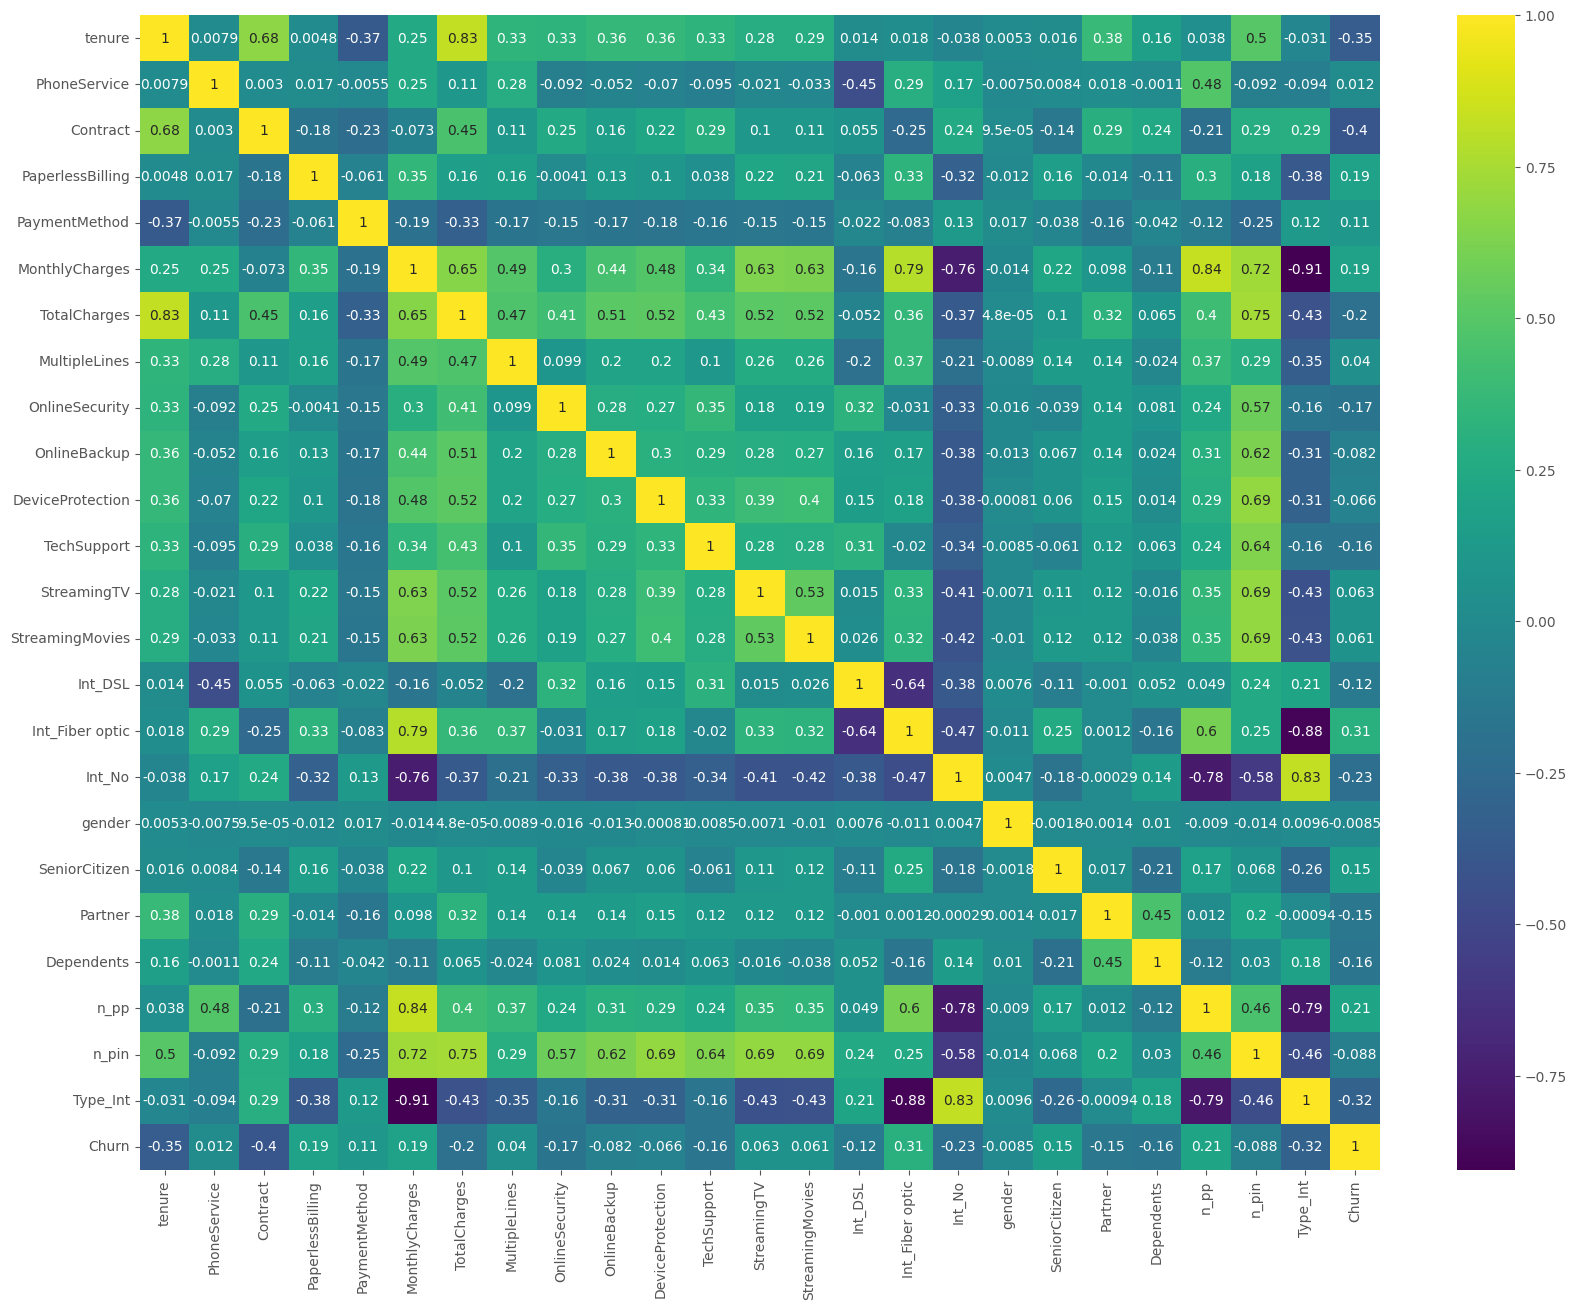

In [469]:
plt.figure(figsize=(20,15))

sns.heatmap(df.corr(),annot=True, cmap='viridis');

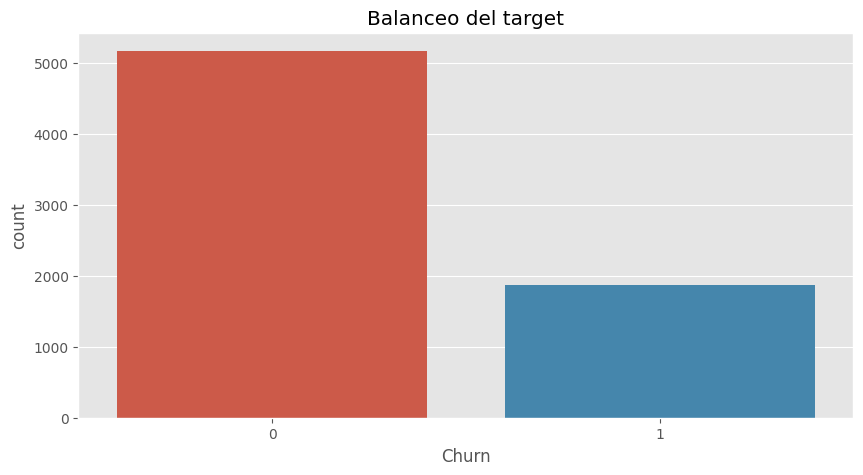

In [501]:

fig, axes = plt.subplots(1, 1, figsize=(10, 5))

sns.countplot(x='Churn',data=df)
axes.set_title("Balanceo del target");

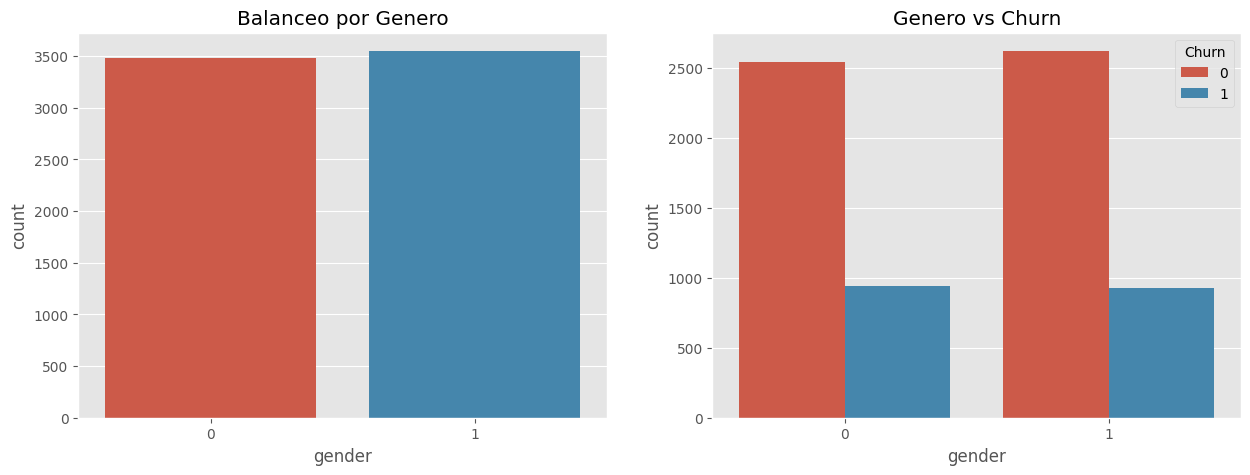

In [502]:


fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Conteo de categorica
sns.countplot(x=df["gender"], ax=axes[0])
axes[0].set_title("Balanceo por Genero")

# Categorica vs target
sns.countplot(x=df["gender"], hue=df['Churn'], ax=axes[1], dodge=True)
axes[1].set_title("Genero vs Churn");

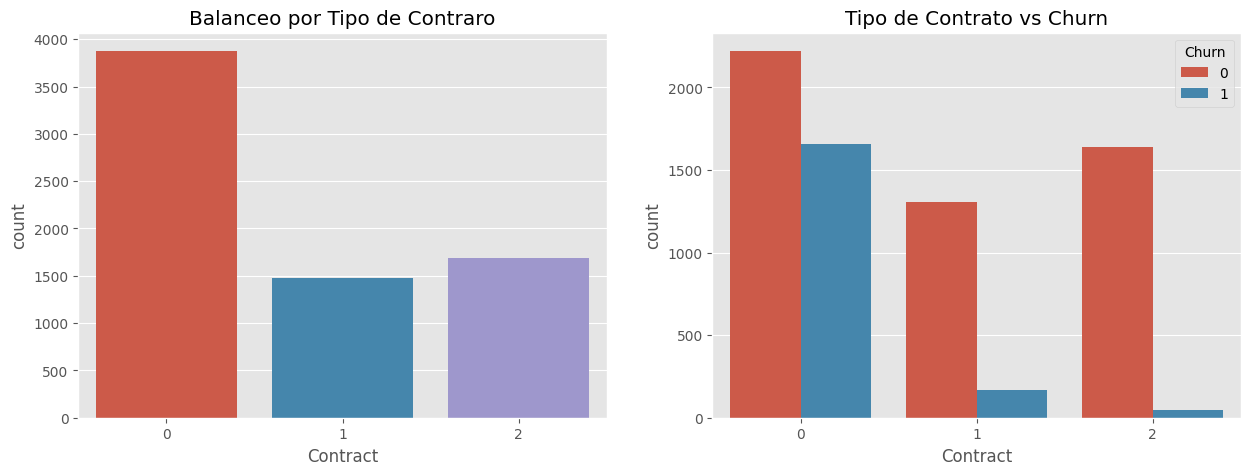

In [503]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Conteo de categorica
sns.countplot(x=df["Contract"], ax=axes[0])
axes[0].set_title("Balanceo por Tipo de Contraro")

# Categorica vs target
sns.countplot(x=df["Contract"], hue=df['Churn'], ax=axes[1], dodge=True)
axes[1].set_title("Tipo de Contrato vs Churn");

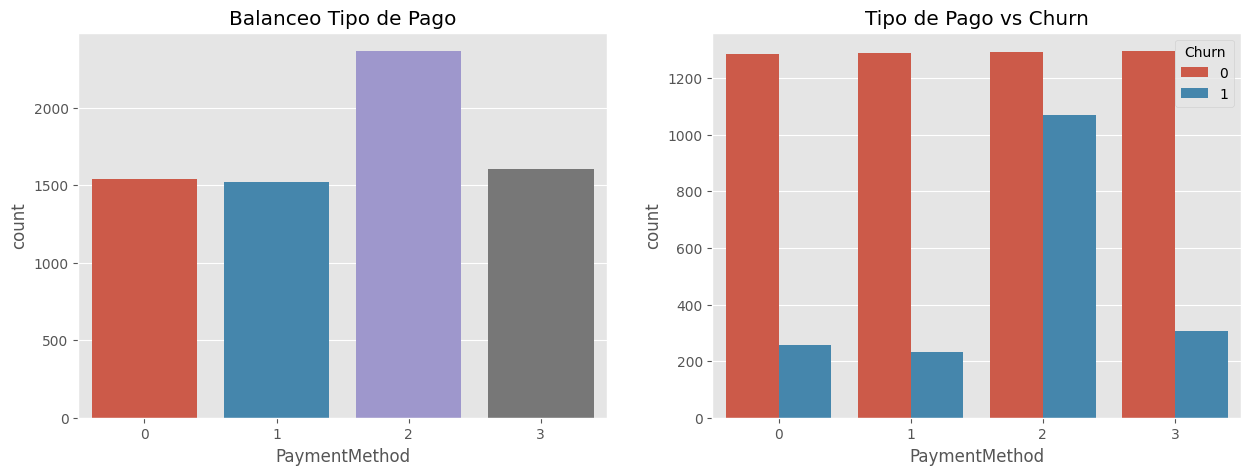

In [504]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Conteo de categorica
sns.countplot(x=df["PaymentMethod"], ax=axes[0])
axes[0].set_title("Balanceo Tipo de Pago")

# Categorica vs target
sns.countplot(x=df["PaymentMethod"], hue=df['Churn'], ax=axes[1], dodge=True)
axes[1].set_title("Tipo de Pago vs Churn");

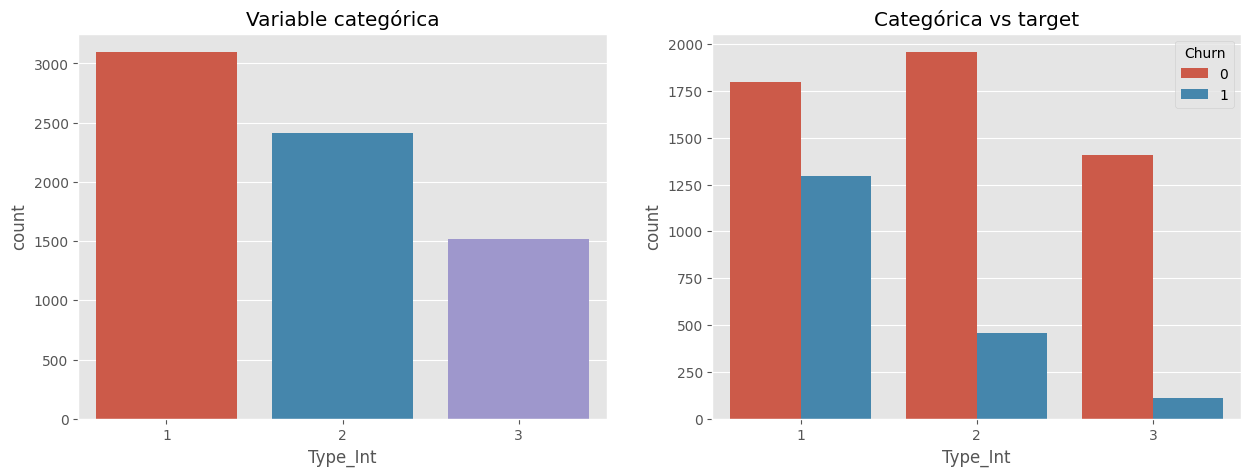

In [505]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Conteo de categorica
sns.countplot(x=df["Type_Int"], ax=axes[0])
axes[0].set_title("Variable categórica")

# Categorica vs target
sns.countplot(x=df["Type_Int"], hue=df['Churn'], ax=axes[1], dodge=True)
axes[1].set_title("Categórica vs target");

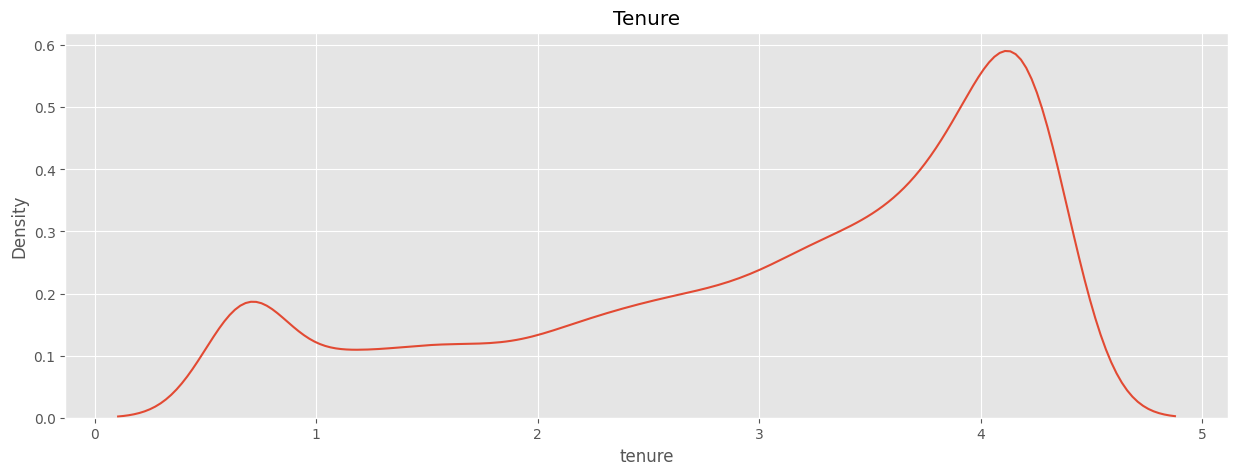

In [474]:
# Funcion de densidad + target
temp=np.log1p(df)

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
sns.kdeplot(data=temp, x='tenure')
axes.set_title("Tenure");

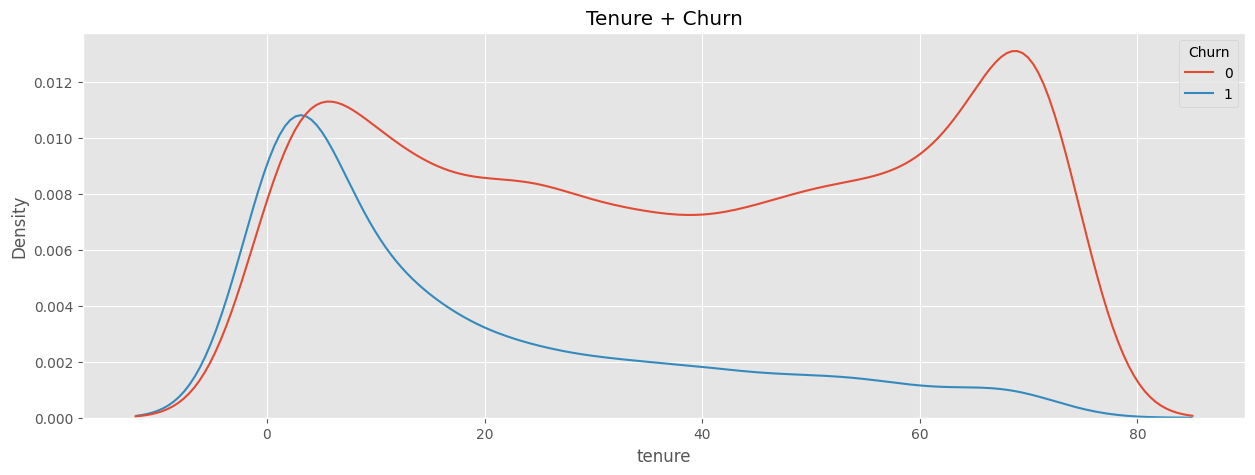

In [475]:
# Funcion de densidad + target
temp=df

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
sns.kdeplot(data=temp, x='tenure', hue = 'Churn')
axes.set_title("Tenure + Churn");

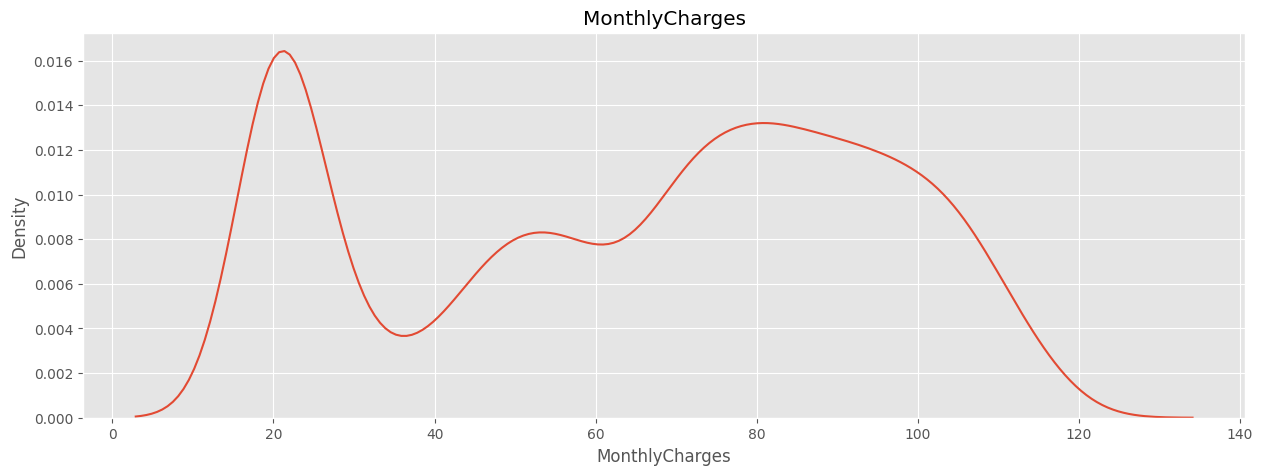

In [476]:
# Funcion de densidad + target
temp=df

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
sns.kdeplot(data=temp, x='MonthlyCharges')
axes.set_title("MonthlyCharges");

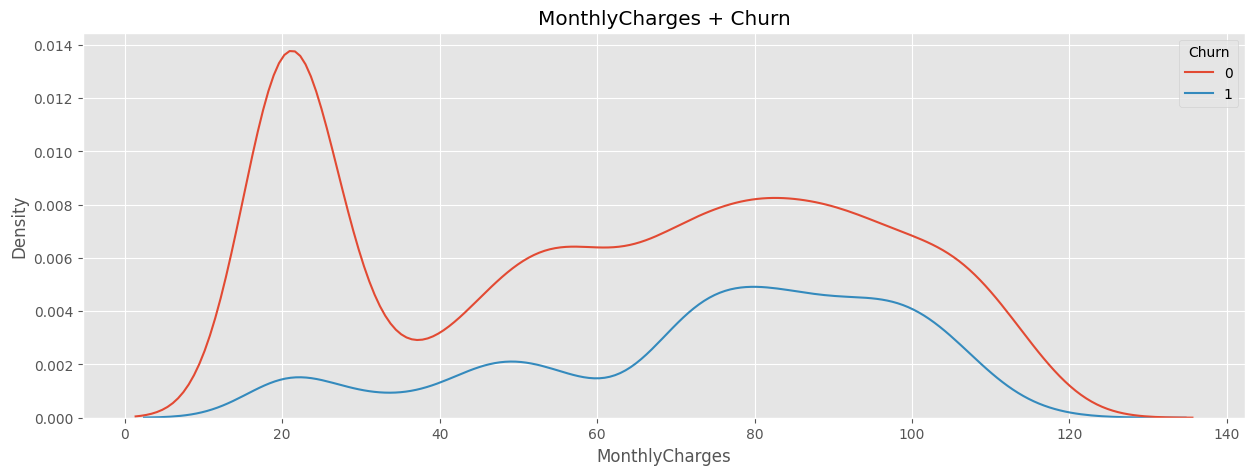

In [477]:
# Funcion de densidad + target
temp=df

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
sns.kdeplot(data=temp, x='MonthlyCharges', hue = 'Churn')
axes.set_title("MonthlyCharges + Churn");

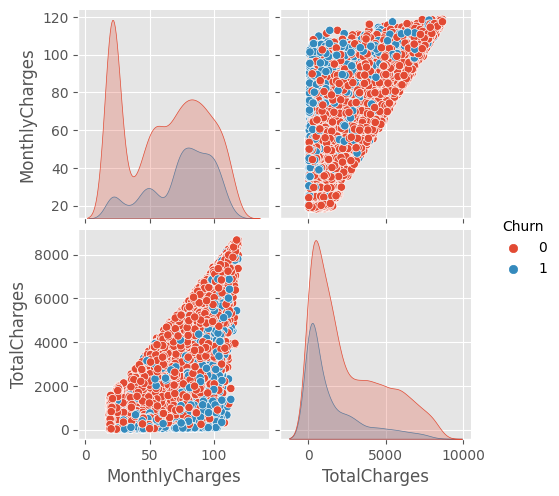

In [478]:
# Variables numericas vs target categórico


temp=df.loc[:,['MonthlyCharges','TotalCharges','Churn']]
sns.pairplot(temp,
            kind='scatter',
            hue='Churn');

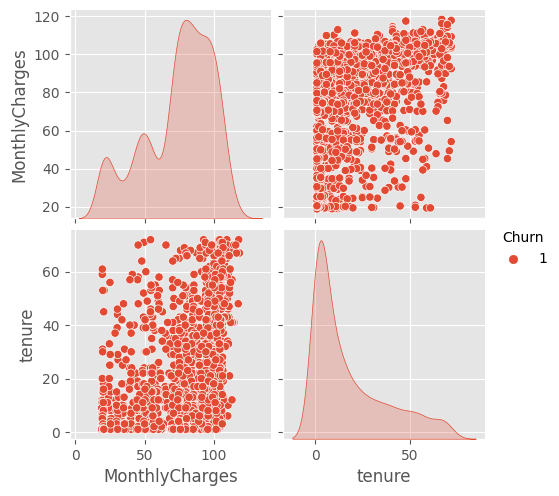

In [479]:
# Variables numericas vs target categórico


temp=df[df['Churn']==1].loc[:,['MonthlyCharges','tenure','Churn']]
sns.pairplot(temp,
            kind='scatter',
            hue='Churn');

### Preproceso

In [480]:
df['tenure']=np.log1p(df['tenure'])
df['MonthlyCharges']=np.log1p(df['MonthlyCharges'])


In [481]:
#df=df.loc[:,['Contract','tenure','Type_Int','Int_Fiber optic','MonthlyCharges','Churn']]

In [482]:
X=df.iloc[:,0:-1]
y=df.iloc[:,-1:]

In [483]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y,test_size=0.2, random_state=8)

In [484]:
select_feature = SelectKBest(f_classif, k=24).fit(X_train, y_train)
selected_features_df = pd.DataFrame({'Feature':list(X_train.columns),
                                     'Scores':select_feature.scores_})
selected_features_df.sort_values(by='Scores', ascending=False)

Feature       Scores
2           Contract  1052.786280
0             tenure   946.672939
23          Type_Int   656.895158
15   Int_Fiber optic   614.243194
16            Int_No   324.632543
5     MonthlyCharges   276.250589
21              n_pp   266.226805
6       TotalCharges   221.443704
3   PaperlessBilling   207.190174
8     OnlineSecurity   171.759047
20        Dependents   140.125931
11       TechSupport   139.599241
18     SeniorCitizen   138.476166
19           Partner   117.289814
14           Int_DSL    89.873925
4      PaymentMethod    60.329534
9       OnlineBackup    41.761107
22             n_pin    40.537745
10  DeviceProtection    29.033726
13   StreamingMovies    26.773523
12       StreamingTV    26.303776
7      MultipleLines    10.435304
17            gender     0.790913
1       PhoneService     0.399523

In [485]:
rfc = Pipeline(steps=[
    ("selectkbest", SelectKBest()),
    ("rfc",RandomForestClassifier())
])

rfc_param = {    
    'selectkbest__score_func':[f_classif],
    'selectkbest__k': [5],
    "rfc__n_estimators": [50,100],
    "rfc__max_features": [3,4,5],
    "rfc__max_depth": [9,11],
    'rfc__criterion' : ['gini']
}

In [486]:
gs_rfc = GridSearchCV(rfc,
                         rfc_param,
                         cv = 10,
                         scoring = 'recall',
                         verbose = 1,
                         n_jobs = -1)

In [487]:
grids = {#"gs_reg_log": gs_reg_log,
        "gs_rfc": gs_rfc,
        #"gs_svm": gs_svm,
        #"gs_knn": gs_knn,
        #"gs_dtree": gs_Dtree   
        
        }

In [488]:
for nombre, grid_search in grids.items():
    grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


In [489]:
print(gs_rfc.best_score_)
print(gs_rfc.best_params_)
print(gs_rfc.best_estimator_)

0.5325190156599552
{'rfc__criterion': 'gini', 'rfc__max_depth': 11, 'rfc__max_features': 5, 'rfc__n_estimators': 50, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_classif at 0x0000026422C67AF8>}
Pipeline(steps=[('selectkbest', SelectKBest(k=5)),
                ('rfc',
                 RandomForestClassifier(max_depth=11, max_features=5,
                                        n_estimators=50))])


In [490]:
predictions = gs_rfc.predict(X_test)
print(accuracy_score(y_test, predictions))

0.7583511016346838


In [491]:
recall_score(y_test, predictions)

0.44919786096256686

In [492]:
precision_score(y_test, predictions)

0.5562913907284768

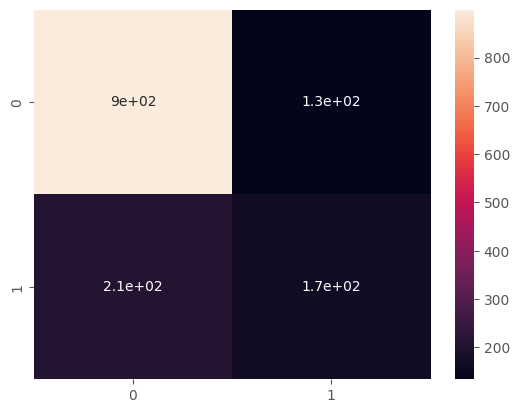

In [493]:
sns.heatmap(confusion_matrix(y_test,predictions), annot=True);

In [494]:
'''import pickle

with open('PMLJavierL', 'wb') as archivo_salida:
    pickle.dump(gs_rfc, archivo_salida)

archivo_salida.close()'''

"import pickle\n\nwith open('PMLJavierL', 'wb') as archivo_salida:\n    pickle.dump(gs_rfc, archivo_salida)\n\narchivo_salida.close()"

In [495]:
'''X_test.to_csv('data\\X_test.csv',index=False)
y_test.to_csv('data\\y_test.csv',index=False)'''

"X_test.to_csv('data\\X_test.csv',index=False)\ny_test.to_csv('data\\y_test.csv',index=False)"

In [496]:
'''import pickle
with open('PMLJavierL', 'rb') as archivo_entrada:
    loaded_model = pickle.load(archivo_entrada)'''

"import pickle\nwith open('PMLJavierL', 'rb') as archivo_entrada:\n    loaded_model = pickle.load(archivo_entrada)"

In [497]:
'''X_test=pd.read_csv('data\\X_test.csv')'''

"X_test=pd.read_csv('data\\X_test.csv')"

In [498]:
'''loaded_model.predict(X_test)''''

SyntaxError: EOL while scanning string literal (2599300540.py, line 1)